In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib qt

In [4]:
from renewableopt.data import DATASET_DIR, load_excel, write_results
from renewableopt.sensitivity import (
    run_sensitivity, sensitivity_dataframe, create_plotting_artifact,
    plot_yearly_peak_dispatch)
from renewableopt.optimal_design import visualize
import numpy as np

In [6]:
active_dir = DATASET_DIR / "sensitivity_check" 

In [7]:
filename = active_dir / "sensitivity.xlsx"
costs, loads, generation = load_excel(filename)

In [8]:
generation[20:50]

,solar,wind,geothermal
Time (hr),,,
20.000000,0.0,1.000000,1
20.083333,0.0,1.000000,1
20.166667,0.0,1.000000,1
20.250000,0.0,1.000000,1
20.333333,0.0,1.000000,1
...,...,...,...
49.666667,0.0,0.092107,1
49.750000,0.0,0.091078,1
49.833333,0.0,0.090049,1


In [9]:
costs

,Scenario 1: Base Case,Scenario 2: No Geothermal
Solar (K/MW),1250,1250
Wind cost (K/MW),1250,1250
Geothermal cost (K/MW),3500,100000000
Battery energy cost (K/MWh),300,300
Battery power cost (K/MW),350,350


In [10]:
loads

,Base Case,100%,75%,50%,25%
0,37.543492,31.977903,33.369300,34.760697,36.152095
1,37.367223,31.827765,33.212630,34.597494,35.982358
2,37.269834,31.744814,33.126069,34.507324,35.888579
3,37.098413,31.598805,32.973707,34.348609,35.723511
4,37.016007,31.528615,32.900463,34.272311,35.644159
...,...,...,...,...,...
105403,41.933907,35.861970,37.305072,38.897939,40.430899
105404,41.725028,35.683337,37.119251,38.704183,40.229507
105405,41.518353,35.506588,36.935389,38.512470,40.030240
105406,41.294051,35.314764,36.735847,38.304408,39.813977


# Outputs of Sensitivity

1. Optimal Capacities
2. Day at which peak occurs
3. Total cost of capacity
4. Names of Scenarios
5. Dispatch stack for each scenario
6. Type of clustering required

In [11]:
results = run_sensitivity(generation, loads, costs)

Base Case Scenario 1: Base Case
Base Case Scenario 2: No Geothermal
100% Scenario 1: Base Case
100% Scenario 2: No Geothermal
75% Scenario 1: Base Case
75% Scenario 2: No Geothermal
50% Scenario 1: Base Case
50% Scenario 2: No Geothermal
25% Scenario 1: Base Case
25% Scenario 2: No Geothermal


In [231]:
_, dispatch = results[("Base Case", "Scenario 2: No Geothermal")]
# _, dispatch = results[("Base Case", "Scenario 1: Base Case")]

In [79]:
def print_capacity_result(dispatch):
    res = dispatch.result
    print("Battery energy (MWh):", res.E_max)
    print("Battery Power (MW):", res.P_battery)
    for i, source in enumerate(dispatch.sources):
        print(f"{source}: ", res.P_generation[i])
    print(f"Total cost (Million): ", res.total_cost / 1000)

In [80]:
print_capacity_result(dispatch)

Battery energy (MWh): 916.2450380146718
Battery Power (MW): 417.2947644185242
solar:  454.59624198194547
wind:  7582.207582028922
geothermal:  0.0
Total cost (Million):  10466.93145896447


In [ ]:
gen_pu = np.array(generation)

# Check that worst cases are feasible

In [114]:
worst_cases = dispatch.worst_cases()

In [120]:
def group_with_lowest_min(worst_cases):
    worst_group = None
    worst_soc = np.inf
    for grp, disp in worst_cases.items():
        min_soc = np.min(disp.soc)
        if min_soc < worst_soc:
            worst_soc = min_soc
            worst_group = grp
    return worst_group

In [121]:
def group_with_lowest_max(worst_cases):
    lowest_max_group = None
    lowest_max_soc = np.inf
    for grp, disp in worst_cases.items():
        min_soc = np.max(disp.soc)
        if min_soc < lowest_max_soc:
            lowest_max_soc = min_soc
            lowest_max_group = grp
    return lowest_max_group

In [122]:
lowest_min_group = group_with_lowest_min(worst_cases)
lowest_max_group = group_with_lowest_max(worst_cases)

In [123]:
lowest_min_disp = worst_cases[lowest_min_group]
lowest_max_disp = worst_cases[lowest_max_group]

In [126]:
print(lowest_min_disp.feasible)
print(lowest_max_disp.feasible)

True
False


## Analysis
Well, somehow optimization is not satisfying the worst case constraints.... There's a bug somewhere.

In [99]:
for disp in worst_cases.values():
    print_capacity_result(disp)

Battery energy (MWh): 916.2450380146718
Battery Power (MW): 417.2947644185242
solar:  454.59624198194547
wind:  7582.207582028922
geothermal:  0.0
Total cost (Million):  10466.93145896447
Battery energy (MWh): 916.2450380146718
Battery Power (MW): 417.2947644185242
solar:  454.59624198194547
wind:  7582.207582028922
geothermal:  0.0
Total cost (Million):  10466.93145896447
Battery energy (MWh): 916.2450380146718
Battery Power (MW): 417.2947644185242
solar:  454.59624198194547
wind:  7582.207582028922
geothermal:  0.0
Total cost (Million):  10466.93145896447
Battery energy (MWh): 916.2450380146718
Battery Power (MW): 417.2947644185242
solar:  454.59624198194547
wind:  7582.207582028922
geothermal:  0.0
Total cost (Million):  10466.93145896447
Battery energy (MWh): 916.2450380146718
Battery Power (MW): 417.2947644185242
solar:  454.59624198194547
wind:  7582.207582028922
geothermal:  0.0
Total cost (Million):  10466.93145896447
Battery energy (MWh): 916.2450380146718
Battery Power (MW): 

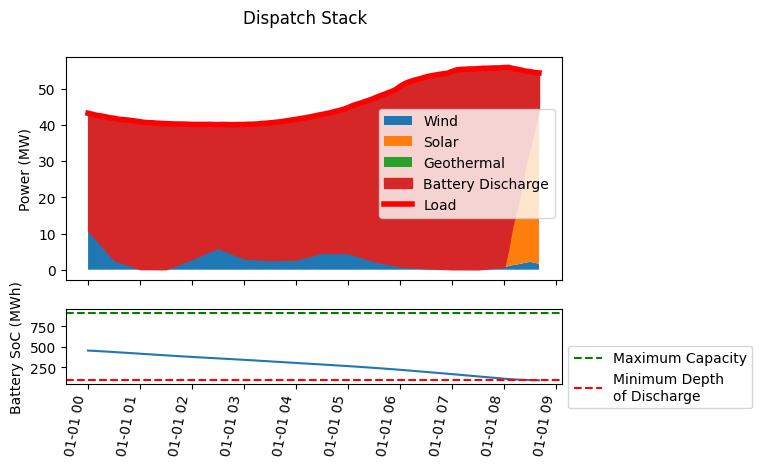

In [97]:
visualize.plot_stack(lowest_max_disp)

# Dispatch improvement

In [239]:
def lowest_gen_dispatch(start_dispatch, delta_index, increment_amount):
    new_dispatch = start_dispatch
    i = 0
    delta_P_gen = np.zeros(3)
    delta_P_gen[delta_index] = -increment_amount
    while new_dispatch.feasible:
        last_feasible = new_dispatch
#         print(f"Incrementing {delta_P_gen * (i + 1)}")
#         print_capacity_result(new_dispatch)
#         print(new_dispatch.time.shape)
        new_dispatch = new_dispatch.increment_capacity(
            0, 0, delta_P_gen, gen_pu
        )
        i += 1
    return last_feasible


In [242]:
DELTA_E = 50

def lower_cost_dispatch(start):
#     min_cost = start.result.total_cost
#     new_dispatch = start.increment_capacity(
#         0, DELTA_E, np.zeros(3), gen_pu)
#     new_dispatch = lowest_wind_dispatch(new_dispatch)
    min_cost = np.inf
    new_dispatch = start
    
    i = 0
    while min_cost > new_dispatch.result.total_cost:
        best_dispatch = new_dispatch
        min_cost = new_dispatch.result.total_cost
        print(f"Increment {i}")
        new_dispatch = lowest_gen_dispatch(
            new_dispatch.increment_capacity(
                0, DELTA_E, np.zeros(3), gen_pu), 1, 20
        )
        i += 1
    return best_dispatch
        

In [254]:
3500 * np.max(loads)

371373.68415

In [243]:
best_dispatch = lower_cost_dispatch(dispatch)

Increment 0
Increment 1
Increment 2
Increment 3
Increment 4
Increment 5
Increment 6
Increment 7
Increment 8
Increment 9
Increment 10
Increment 11
Increment 12
Increment 13
Increment 14
Increment 15
Increment 16
Increment 17
Increment 18
Increment 19
Increment 20
Increment 21
Increment 22
Increment 23
Increment 24
Increment 25
Increment 26
Increment 27
Increment 28
Increment 29


In [235]:
best_dispatch == dispatch

False

In [244]:
print_capacity_result(best_dispatch)

Battery energy (MWh): 2366.245038014672
Battery Power (MW): 417.2947644185242
solar:  454.59624198194547
wind:  42.207582028921934
geothermal:  0.0
Total cost (Million):  1476.9314589644694


In [226]:
print_capacity_result(dispatch)

Battery energy (MWh): 111.43601022598436
Battery Power (MW): 20.596439997939193
solar:  26.142967483141206
wind:  0.0
geothermal:  72.11489010093774
Total cost (Million):  325.72038177428266


In [225]:
print_capacity_result(best_dispatch)

Battery energy (MWh): 161.43601022598438
Battery Power (MW): 20.596439997939193
solar:  26.142967483141206
wind:  0.0
geothermal:  72.11489010093774
Total cost (Million):  340.72038177428266


In [59]:
from renewableopt.sensitivity import find_peak_day

In [60]:
day = find_peak_day(new_dispatch)

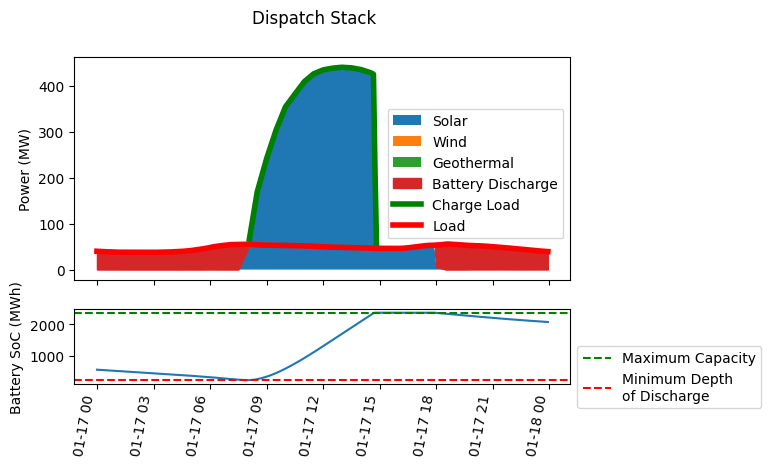

In [251]:
plot_yearly_peak_dispatch(best_dispatch)

In [131]:
find_peak_day(best_dispatch)

16

In [247]:
plt.ion()

In [248]:
visualize.min_capacity_per_month(best_dispatch, [12])

[<Figure size 640x480 with 2 Axes>]

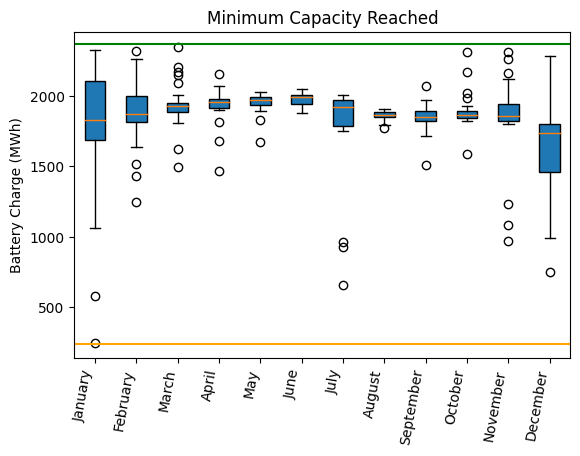

In [250]:
visualize.storage_capacity_statistics(best_dispatch)

In [ ]:
find_peak_day

In [19]:
import matplotlib.pyplot as plt

In [113]:
min_soc = np.min(best_dispatch.per_day().soc, axis=1)
plt.figure()
plt.plot(min_soc)

In [20]:
from renewableopt.optimal_design.dispatch import day_indices

In [21]:
# Double check that capacity factors make sense...


In [22]:
from renewableopt.peak_id import timedelta

In [158]:
np.array(generation.index)

array([0.00000000e+00, 8.33333333e-02, 1.66666667e-01, ...,
       8.78375000e+03, 8.78383333e+03, 8.78391667e+03])

In [160]:
list(generation.columns).index('solar')

0

In [170]:
np.array(generation.iloc[0:20, 2])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
def capacity_factor(dispatch, day, source, curtail=False):
    source_i = dispatch.sources.index(source)
    ind = day_indices(dispatch.time, day)
    if curtail:
        gen = dispatch.curtailed_generation()[ind]
    else:
        gen = dispatch.gen[ind]
    dt = dispatch.result.dt
    total_gen = np.sum(gen[:, source_i]) * dt
    max_gen = dispatch.result.P_generation[source_i] * 24
    return total_gen / max_gen
    
def capacity_factor_from_pu(generation, day, source):
    source_i = list(generation.columns).index(source)
    time = np.array(generation.index)
    ind = day_indices(time, day)
    dt = timedelta(time)
    gen = np.array(generation.iloc[ind, source_i])
    total_gen = np.sum(gen) * dt
    max_gen = 24
    return total_gen / max_gen
    

In [14]:
generation_correct = generation.copy()

In [17]:
generation_correct["wind"] *= np.pi
generation_correct["wind"] = np.clip(generation_correct["wind"], None, 1)

In [23]:
dt = timedelta(np.array(generation.index))

In [24]:
for source in generation.columns:
    cap = generation[source].sum() * dt / 24 / 366
    print(f"{source}: {cap}")

solar: 0.2818351125210254
wind: 0.12759024141253672
geothermal: 1.0


In [25]:
for source in generation.columns:
    cap = generation_correct[source].sum() * dt / 24 / 366
    print(f"{source}: {cap}")

solar: 0.2818351125210254
wind: 0.24349790944096955
geothermal: 1.0


In [40]:
f"{10.111:.2f}"

'10.11'

In [36]:
np.mean(np.ones((3, 3)), axis=0).shape

(3,)

In [38]:
list(generation.columns).index("wind")

1

In [51]:
def capacity_factor_plot(generation, columns=None):
    gen_pu = np.array(generation)
    gen_pu_per_day = gen_pu.reshape(366, -1, 3)
    daily_cap = np.sum(gen_pu_per_day, axis=1) * dt / 24
    daily_cap *= 100  # Convert to percent.
    
    plt.figure()
    yearly_cap = np.mean(daily_cap, axis=0)
    if columns is None:
        columns = generation.columns
    for source in columns:
        i = list(generation.columns).index(source)
        plt.plot(np.sort(daily_cap[:, i])[::-1], label=source)
    for j, source in enumerate(columns):
        i = list(generation.columns).index(source)
        label = f"Yearly Capacity Factor: {source.capitalize()} ({yearly_cap[i]:.1f})"
        plt.axhline(y=yearly_cap[i], linestyle='--', color=f"C{j}", label=label)
    
    plt.title("Solar and Wind Daily Capacity Factors")
    plt.xlabel("Number of days with at least x capacity factor")
    plt.ylabel("Capacity factor (%)")
    plt.legend()


In [50]:
capacity_factor_plot(generation, ['solar', 'wind'])

In [52]:
capacity_factor_plot(generation_correct, ['solar', 'wind'])

In [ ]:
for source in generation.columns:
    cap = generation[source].sum() * dt / 24 / 366
    print(f"{source}: {cap}")

In [ ]:
np.sum(np.array(generation)

In [206]:
source = "solar"
day = np.datetime64("2012-01-17")

print(capacity_factor(best_dispatch, day, source, curtail=True))
print(capacity_factor_from_pu(generation, day, source))

0.18706914104462555
0.3222272992530345


In [187]:
print_capacity_result(last_feasible)

Battery energy (MWh): 1016.2450380146718
Battery Power (MW): 417.2947644185242
solar:  454.59624198194547
wind:  2082.207582028922
geothermal:  0.0
Total cost (Million):  3621.9314589644696


In [185]:
visualize.min_capacity_per_month(best_dispatch, [7])

[<Figure size 640x480 with 2 Axes>]

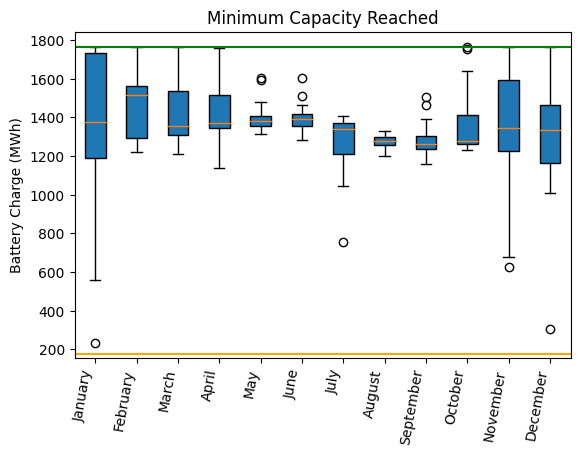

In [207]:
visualize.storage_capacity_statistics(best_dispatch)

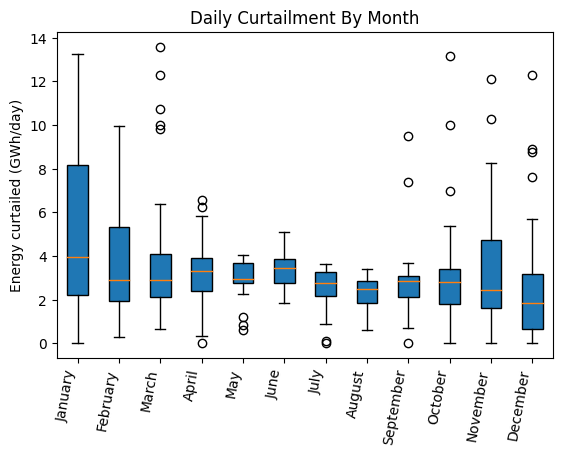

In [208]:
visualize.daily_curtailment(best_dispatch)

In [21]:
visualize.min_capacity_per_month(new_dispatch, [11])

[<Figure size 640x480 with 2 Axes>]

In [29]:
dispatch.result.E_max

931.50436427488

In [28]:
dispatch.result.P_generation

array([3542.40229442, 4194.93443458,    0.        ])

In [32]:
dispatch.result.total_cost

10113236.468984254

In [31]:
dispatch.result.P_battery

463.18356702605547

In [27]:
new_dispatch.result.P_generation

array([3542.40229442, 4194.93443458,    0.        ])

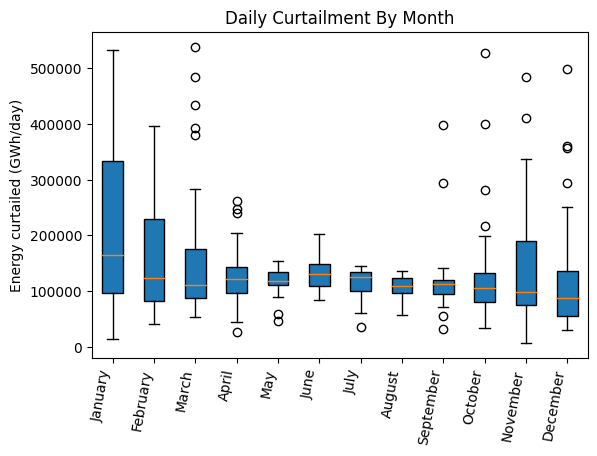

In [26]:
visualize.daily_curtailment(new_dispatch)

In [19]:
dispatch.result.P_generation

array([3542.40229442, 4194.93443458,    0.        ])

In [214]:
save_dir = DATASET_DIR / "presentation_images"

In [81]:
import matplotlib.pyplot as plt

In [212]:
plots = {
    "peak_dispatch": plot_yearly_peak_dispatch,
    "dec_dispatch": lambda d: visualize.min_capacity_per_month(d, [12])[0],
    "daily_curtailment": visualize.daily_curtailment,
    "storage_stats": visualize.storage_capacity_statistics,
}

In [218]:
name = "peak_dispatch"
plt.ioff()
fig = plots[name](best_dispatch)
fig.set_size_inches([4, 4])
fig.savefig(save_dir / f"no_geo_{name}.png", bbox_inches='tight')
plt.close()

In [14]:
df = sensitivity_dataframe(results, loads, costs, generation)

In [15]:
df

,Load Scenario,Cost Scenario,Battery Energy Installed (MWh),Battery Power Installed (MW),Solar Installed (MW),Wind Installed (MW),Geothermal Installed (MW),Hours of storage,Total cost of Capacity (Million USD),Load served over year (GWh),Energy cost ($/KWh),Peak Date,Clustering Method
0,Base Case,Scenario 1: Base Case,111.436010,20.596440,26.142967,0.000000,72.114890,5.410450,325.720382,408.658650,0.797048,2012-08-13,Solar only
1,Base Case,Scenario 2: No Geothermal,916.245038,417.294764,454.596242,7582.207582,0.000000,2.195678,10466.931459,408.658650,25.612896,2012-12-22,KMeans (Wind and solar)
2,100%,Scenario 1: Base Case,103.624255,19.361787,24.722781,0.000000,63.266406,5.351999,290.199798,351.561664,0.825459,2012-08-13,Solar only
3,100%,Scenario 2: No Geothermal,795.018506,397.219842,3001.197433,3647.291079,0.000000,2.001457,8688.143136,351.561664,24.712999,2012-12-22,KMeans (Wind and solar)
4,75%,Scenario 1: Base Case,101.070133,18.728526,23.807342,0.000000,64.522730,5.396588,292.464755,364.030439,0.803407,2012-08-13,Solar only
5,75%,Scenario 2: No Geothermal,812.310727,315.898649,2085.803560,3189.846149,0.000000,2.571428,6948.819881,364.030439,19.088568,2012-12-22,KMeans (Wind and solar)
6,50%,Scenario 1: Base Case,107.541798,19.980188,25.436926,0.000000,67.688019,5.382422,307.959830,380.110157,0.810186,2012-08-13,Solar only
7,50%,Scenario 2: No Geothermal,849.636714,389.496589,2920.918733,2013.685635,0.000000,2.181371,6559.470280,380.110157,17.256761,2012-12-22,KMeans (Wind and solar)
8,25%,Scenario 1: Base Case,110.393816,20.477021,26.045260,0.000000,70.091825,5.391107,318.163066,394.745498,0.805995,2012-08-13,Solar only
9,25%,Scenario 2: No Geothermal,905.632584,454.129757,2974.747336,4838.285426,0.000000,1.994215,10196.926143,394.745498,25.831646,2012-12-22,KMeans (Wind and solar)


## Write sensitivity results to excel

In [25]:
write_results(filename, df)

Sensitivity results sheet already exists. Replace results? [y/n]y


# Save visualization images

In [22]:
create_plotting_artifact(active_dir / "Images", results)